Analyzing BRK-B...


Analyzing AAPL...


Analyzing TSLA...


Analyzing AMZN...


Analyzing GDDY...


Analyzing TGT...


Analyzing URBN...


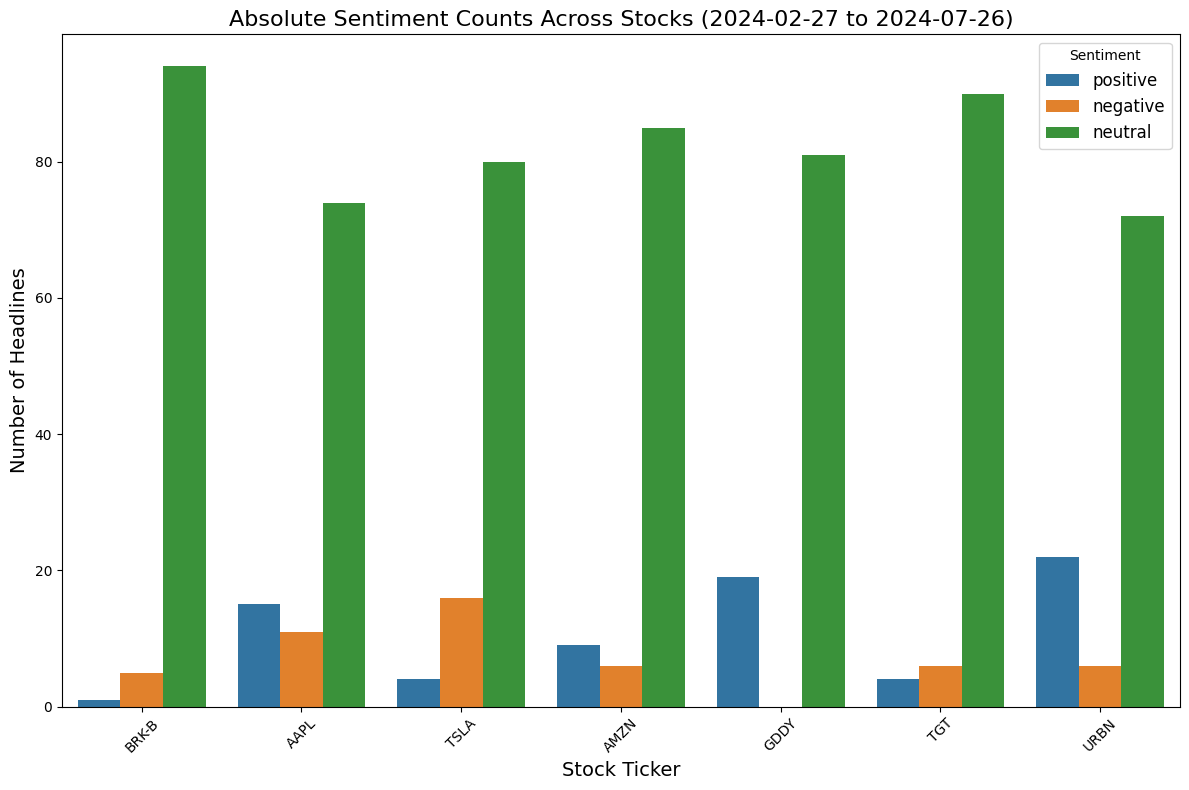

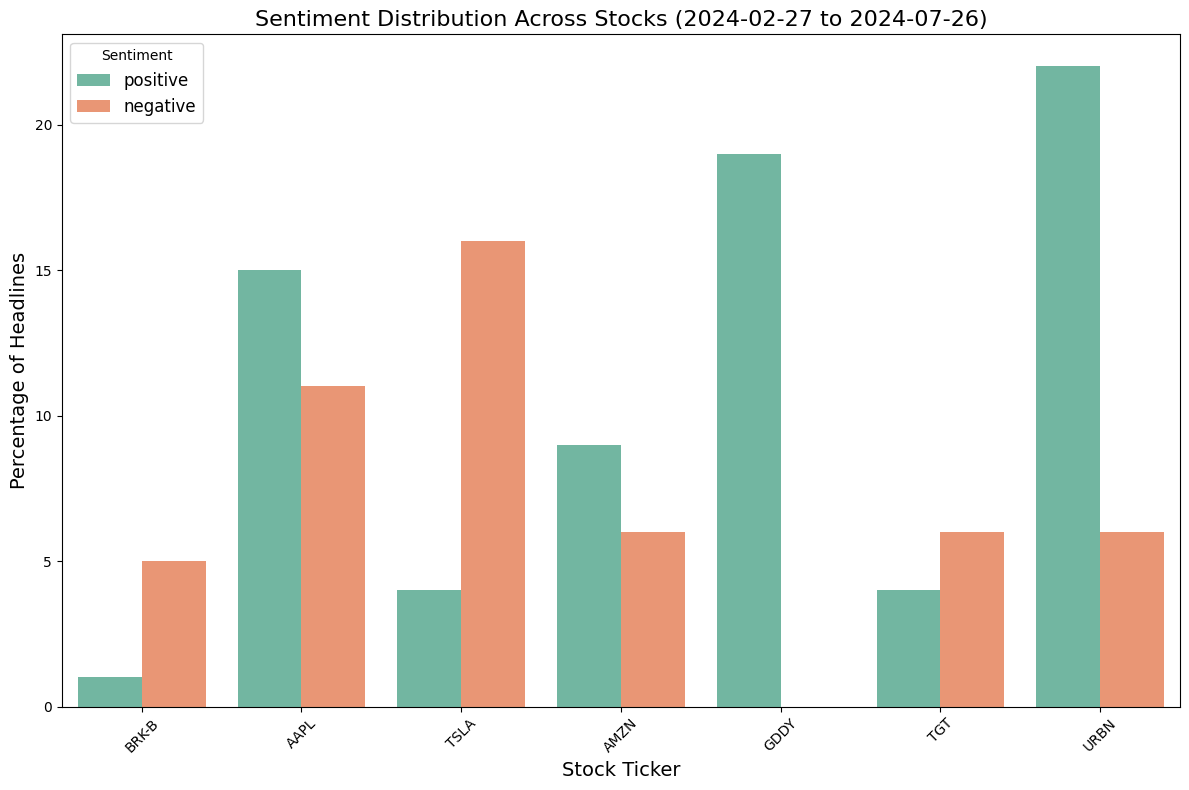

In [24]:
import requests
from bs4 import BeautifulSoup
from fastai.text.all import load_learner
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
import re

# Load the trained model
learn = load_learner('../input/classifier-model/fin_news_classifier_model.pkl')

def get_stock_news(stock_ticker):
    """
    Fetch headlines and timestamps from FINVIZ for a specific stock ticker.
    """
    url = f'https://finviz.com/quote.ashx?t={stock_ticker}'
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        headlines = [h.text.strip() for h in soup.find_all('a', class_='tab-link-news')]
        timestamps = [td.text.strip() for td in soup.find_all('td', width='130', align='right')]
        return headlines, timestamps
    else:
        print(f"Failed to retrieve data from FINVIZ for {stock_ticker}")
        return [], []

def predict_sentiments(headlines):
    results = []
    for headline in headlines:
        pred_class, pred_idx, probs = learn.predict(headline)
        results.append((headline, pred_class))
    return results

def aggregate_sentiments(results):
    # Aggregate the sentiments
    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
    for _, sentiment in results:
        sentiment_counts[sentiment] += 1
    return sentiment_counts

def save_to_csv(all_results):
    # Flatten the results and create a DataFrame
    data = []
    for stock, (headlines, timestamps, sentiments) in all_results.items():
        for headline, timestamp, sentiment in zip(headlines, timestamps, sentiments):
            data.append({
                'Stock': stock,
                'Headline': headline,
                'Timestamp': timestamp,
                'Sentiment': sentiment,
                'ParsedTime': datetime.now()
            })
    df = pd.DataFrame(data)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%b-%d-%y %I:%M%p', errors='coerce')
    df = df.sort_values(by='Timestamp')
    df.to_csv('stock_sentiments.csv', index=False)
    return df

def visualize_sentiments(all_sentiment_counts, date_range, output_file_prefix='sentiment_distribution'):
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(all_sentiment_counts).T
    df = df.reset_index().melt(id_vars='index', var_name='Sentiment', value_name='Count')
    df.rename(columns={'index': 'Stock'}, inplace=True)
    
    # Normalize the data to percentages
    df['Total'] = df.groupby('Stock')['Count'].transform('sum')
    df['Percentage'] = df['Count'] / df['Total'] * 100

    # Absolute Values Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Stock', y='Count', hue='Sentiment', data=df)
    plt.title(f"Absolute Sentiment Counts Across Stocks ({date_range})", fontsize=16)
    plt.xlabel("Stock Ticker", fontsize=14)
    plt.ylabel("Number of Headlines", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_file_prefix}_absolute.png', format='png', dpi=300)
    plt.show()

    # Filter out neutral sentiments for percentage plot
    df_filtered = df[df['Sentiment'] != 'neutral']

    # Percentage Values Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Stock', y='Percentage', hue='Sentiment', data=df_filtered, palette=sns.color_palette("Set2", len(df_filtered['Sentiment'].unique())))
    plt.title(f"Sentiment Distribution Across Stocks ({date_range})", fontsize=16)
    plt.xlabel("Stock Ticker", fontsize=14)
    plt.ylabel("Percentage of Headlines", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_file_prefix}_percentage.png', format='png', dpi=300)
    plt.show()

    
# Main function to run the analysis for multiple tickers
def run_analysis(stock_tickers):
    all_sentiment_counts = {}
    all_results = {}
    
    for ticker in stock_tickers:
        print(f"Analyzing {ticker}...")
        headlines, timestamps = get_stock_news(ticker)
        if headlines:
            results = predict_sentiments(headlines)
            sentiment_counts = aggregate_sentiments(results)
            all_sentiment_counts[ticker] = sentiment_counts
            all_results[ticker] = (headlines, timestamps, [sentiment for _, sentiment in results])
        else:
            print(f"No headlines found for {ticker}. Check the stock ticker or website access.")
        time.sleep(5)  # Wait for 5 seconds before the next request

    df = save_to_csv(all_results)
    date_range = f"{df['Timestamp'].min().strftime('%Y-%m-%d')} to {df['Timestamp'].max().strftime('%Y-%m-%d')}"
    visualize_sentiments(all_sentiment_counts, date_range)

# Example: Analyze news for multiple stocks
stock_tickers = ['BRK-B', 'AAPL', 'TSLA', 'AMZN', 'GDDY', 'TGT', 'URBN']  # Replace with your desired stock tickers
run_analysis(stock_tickers)
